In [1]:
# Importing packages 
import numpy as np
import pandas as pd
import classy
from classy import Class
import camb
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
#print(classy.Class.__doc__)


    Class wrapping, creates the glue between C and python

    The actual Class wrapping, the only class we will call from MontePython
    (indeed the only one we will import, with the command:
    from classy import Class

    


In [3]:
# Quick CLASS test - CORRECTED
cosmo = Class()
cosmo.set({
    'output': 'tCl lCl',  # Need both tCl AND lCl for lensed spectra
    'lensing': 'yes', 
    'A_s': 2.1e-9, 
    'n_s': 0.9649
})
cosmo.compute()
cls = cosmo.lensed_cl(100)
print(f"CLASS TT max value: {np.max(cls['tt'])}")
cosmo.struct_cleanup()

CLASS TT max value: 1.4541421656198878e-10


In [44]:
# Get the proper conversion factor
T_cmb = cosmo.T_cmb()  # Get CMB temperature from CLASS
print(f"CMB temperature: {T_cmb} K")

# Convert to μK²
conversion_factor = (T_cmb * 1e6)**2
print(f"Conversion factor to μK²: {conversion_factor:.2e}")

# Apply conversion
cls_tt_muK2 = cls['tt'] * conversion_factor
print(f"CLASS TT max in μK²: {np.max(cls_tt_muK2):.1f}")

# To match CAMB format (D_ℓ), also need ℓ(ℓ+1)/(2π)
ell = cls['ell']
dl_tt = ell * (ell + 1) * cls_tt_muK2 / (2 * np.pi)
print(f"CLASS D_ℓ^TT max in μK²: {np.max(dl_tt[2:]):.1f}")  # Skip ℓ=0,1

CMB temperature: 2.7255 K
Conversion factor to μK²: 7.43e+12
CLASS TT max in μK²: 1078.4
CLASS D_ℓ^TT max in μK²: 5615.1


In [12]:
class CosmologyComparison:
    def __init__(self):  # Fixed: was **init**
        """Initialize the comparison framework with matched accuracy settings"""
        
        # CLASS accuracy settings
        self.class_accuracy = {
            'k_min_tau0': 0.002,
            'k_max_tau0_over_l_max': 3.0,
            'l_max_scalars': 2500,               # Starting smaller for testing, will update
            'P_k_max_h/Mpc': 1.0,
            'tol_background_integration': 1.e-4,
        }
        
        # CAMB accuracy settings  
        self.camb_accuracy = {
            'AccuracyBoost': 1.5,
            'lSampleBoost': 2.0,
            'lAccuracyBoost': 2.0,
            'DoLateRadTruncation': False
        }
        
        # Common ranges
        self.k_array = np.logspace(-4, 0, 50)  # h/Mpc
        self.l_array = np.arange(2, 2501)      # 0 and 1 skipped since they give 0
        self.z_array = np.array([0, 0.5, 1.0, 2.0, 3.0])
        
    def generate_test_cosmologies(self, n_cosmologies=10):
        """Generate test cosmologies covering parameter space"""
        
        # Base Planck 2018 cosmology
        base_cosmo = {
            'omega_b': 0.02237,
            'omega_cdm': 0.12,
            'h': 0.6736,
            'A_s': 2.1e-9,
            'n_s': 0.9649,
            'tau_reio': 0.0544
        }
        
        cosmologies = [base_cosmo.copy()]  # First, the fiducial
        
        # Add variations
        variations = [
            {'omega_b': 0.021, 'label': 'low_omega_b'},
            {'omega_b': 0.024, 'label': 'high_omega_b'},
            {'omega_cdm': 0.11, 'label': 'low_omega_cdm'}, 
            {'omega_cdm': 0.13, 'label': 'high_omega_cdm'},
            {'h': 0.65, 'label': 'low_h'},
            {'h': 0.70, 'label': 'high_h'},
            {'n_s': 0.95, 'label': 'low_n_s'},
            {'n_s': 0.98, 'label': 'high_n_s'},
            {'tau_reio': 0.04, 'label': 'low_tau'}
        ]
        
        for i, var in enumerate(variations[:n_cosmologies-1]):
            cosmo = base_cosmo.copy()
            cosmo.update({k: v for k, v in var.items() if k != 'label'})
            cosmo['label'] = var['label']
            cosmologies.append(cosmo)
            
        cosmologies[0]['label'] = 'fiducial'
        
        return cosmologies
    
    def run_class(self, cosmo_params):
        """Run CLASS with given cosmology parameters"""
        try:
            cosmo = Class()

            # Create a clean parameter dictionary
            params = {}

            # Copy all parameters except 'label'
            for key, value in cosmo_params.items():
                if key != 'label':
                    params[key] = value

            # Add CLASS-specific parameters
            params.update({
                'output': 'tCl,pCl,lCl,mPk', # Fix: use spaces, not commas
                'lensing': 'yes',
                'P_k_max_h/Mpc': 1.0,
                'l_max_scalars': 2500
            })

            # Add precision parameters EXCEPT the ones that might conflict
            for key, value in self.class_accuracy.items():
                if key not in params:  # Don't override existing parameters
                    params[key] = value

            cosmo.set(params)
            cosmo.compute()

            # Extract results
            results = {}

            # CMB power spectra
            cl_dict = cosmo.lensed_cl(2500)
            T_cmb = cosmo.T_cmb()  # Get CMB temperature
            
            results['l'] = cl_dict['ell'][2:]

            # Convert CLASS dimensionless C_ℓ to D_ℓ in μK²
            # ell = cl_dict['ell'][2:]

            # Get the ell array and slice it
            ell_full = cl_dict['ell']
            ell = ell_full[2:]  # Skip ℓ=0,1
        
            factor = (T_cmb * 1e6)**2  # Not 1e12
            
            # results['tt'] = cl_dict['tt'][2:] * factor  # Convert to µK²
            # results['ee'] = cl_dict['ee'][2:] * factor  #    "
            # results['te'] = cl_dict['te'][2:] * factor  #    "
        
            results['l'] = ell
            results['tt'] = ell * (ell + 1) * cl_dict['tt'][2:] * factor / (2 * np.pi)
            results['ee'] = ell * (ell + 1) * cl_dict['ee'][2:] * factor / (2 * np.pi)
            results['te'] = ell * (ell + 1) * cl_dict['te'][2:] * factor / (2 * np.pi)

            # Matter power spectrum
            results['k'] = self.k_array
            results['pk'] = np.array([cosmo.pk(k*cosmo.h(), 0) * cosmo.h()**3 
                                    for k in self.k_array])

            cosmo.struct_cleanup()
            return results

        except Exception as e:
            print(f"CLASS error for {cosmo_params.get('label', 'unknown')}: {e}")
            return None

    
    def run_camb(self, cosmo_params):
        """Run CAMB with given cosmology parameters"""
        try:
            # Set up CAMB parameters
            pars = camb.CAMBparams()
            
            # Cosmology
            pars.set_cosmology(
                H0=cosmo_params['h']*100,
                ombh2=cosmo_params['omega_b'],
                omch2=cosmo_params['omega_cdm'],
                tau=cosmo_params['tau_reio']
            )
            
            # Initial power spectrum
            pars.InitPower.set_params(
                As=cosmo_params['A_s'],
                ns=cosmo_params['n_s']
            )
            
            # Accuracy settings
            for key, val in self.camb_accuracy.items():
                setattr(pars, key, val)
            
            # Set up for CMB and matter power
            pars.set_for_lmax(2500, lens_potential_accuracy=1)
            pars.set_matter_power(redshifts=[0], kmax=1.0)
            
            # Get results
            results_camb = camb.get_results(pars)
            
            # Extract results
            results = {}
            
            # CMB power spectra
            powers = results_camb.get_cmb_power_spectra(pars)
            cl_total = powers['total']
            
            results['l'] = np.arange(2, min(2501, cl_total.shape[0]))
            max_idx = min(2499, cl_total.shape[0]-2)
            results['tt'] = cl_total[2:max_idx+2, 0] * 1e12  # TT
            results['ee'] = cl_total[2:max_idx+2, 1] * 1e12  # EE
            results['te'] = cl_total[2:max_idx+2, 3] * 1e12  # TE
            
            # Matter power spectrum
            k_camb, z_camb, pk_camb = results_camb.get_matter_power_spectrum(
                minkh=self.k_array.min(), maxkh=self.k_array.max(), npoints=len(self.k_array)
            )
            results['k'] = k_camb
            results['pk'] = pk_camb[0, :]  # z=0
            
            return results
            
        except Exception as e:
            print(f"CAMB error for {cosmo_params.get('label', 'unknown')}: {e}")
            return None
    
    def compare_cosmologies(self, n_cosmologies=10):
        """Run comparison across multiple cosmologies"""
        
        cosmologies = self.generate_test_cosmologies(n_cosmologies)
        all_results = []
        
        print(f"Running {len(cosmologies)} cosmologies through both codes...")
        print("="*60)
        
        for i, cosmo in tqdm(enumerate(cosmologies), total=len(cosmologies), desc="Processing"):
            label = cosmo.get('label', f'cosmo_{i}')
            print(f"\nCosmology {i+1}/{len(cosmologies)}: {label}")
            
            # Run CLASS
            print("  Running CLASS...", end=" ")
            class_results = self.run_class(cosmo)
            if class_results:
                print("✓")
            else:
                print("✗")
                continue
                
            # Run CAMB
            print("  Running CAMB...", end=" ")  
            camb_results = self.run_camb(cosmo)
            if camb_results:
                print("✓")
            else:
                print("✗")
                continue
            
            # Store results
            result_entry = {
                'cosmology': label,
                'params': cosmo,
                'class': class_results,
                'camb': camb_results
            }
            all_results.append(result_entry)
            
            # Quick comparison
            tt_diff = np.abs(class_results['tt'] - camb_results['tt']).max()
            pk_diff = np.abs(class_results['pk'] - camb_results['pk']).max() / camb_results['pk'].max()
            print(f"  Max TT diff: {tt_diff:.2e} µK², Max P(k) diff: {pk_diff:.2e}")
        
        print(f"\n✓ Completed {len(all_results)}/{len(cosmologies)} cosmologies successfully")
        return all_results
    
    # Debug version to see what's happening (issue 6/3/25)
    def run_class_debug(self, cosmo_params):
        """Debug version to see what parameters are being set"""
        try:
            cosmo = Class()

            # Create parameters dictionary
            params = cosmo_params.copy()
            params.pop('label', None)

            print(f"Initial params: {params}")

            # Add CLASS-specific parameters
            params.update({
                'output': 'tCl pCl lCl mPk',
                'lensing': 'yes',
            })

            print(f"After adding CLASS params: {params}")

            # Add precision parameters
            params.update(self.class_accuracy)

            print(f"Final params being sent to CLASS: {params}")

            cosmo.set(params)
            cosmo.compute()

            print("Success!")
            cosmo.struct_cleanup()
            return True

        except Exception as e:
            print(f"CLASS error: {e}")
            return False

        # Test
        comp = CosmologyComparison()
        test_cosmo = {
            'omega_b': 0.02237,
            'omega_cdm': 0.12,
            'h': 0.6736,
            'A_s': 2.1e-9,
            'n_s': 0.9649,
            'tau_reio': 0.0544,
            'label': 'test'
        }
        comp.run_class_debug(test_cosmo)
    
    def save_results(self, results, filename='cosmology_comparison.npz'):
        """Save results to file - ONLY if successful results"""
        if not results:  # Don't save if no results
            print("No successful results to save!")
            return
        
        np.savez(filename, results=results)
        print(f"Results saved to {filename}")

In [13]:
# Usage
if __name__ == "__main__":
    # Initialize comparison
    comp = CosmologyComparison()
    
    # Run comparison on 3 cosmologies first (for testing)
    results = comp.compare_cosmologies(3)
    
    # Save results only if we have some
    if results:
        comp.save_results(results)

Running 3 cosmologies through both codes...


Processing:   0%|                                         | 0/3 [00:00<?, ?it/s]


Cosmology 1/3: fiducial
  Running CLASS... ✓
  Running CAMB... 

Processing:  33%|███████████                      | 1/3 [00:06<00:13,  6.77s/it]

✓
  Max TT diff: 4.96e+03 µK², Max P(k) diff: 2.10e-02

Cosmology 2/3: low_omega_b
  Running CLASS... ✓
  Running CAMB... 

Processing:  67%|██████████████████████           | 2/3 [00:13<00:06,  6.68s/it]

✓
  Max TT diff: 4.86e+03 µK², Max P(k) diff: 2.13e-02

Cosmology 3/3: high_omega_b
  Running CLASS... ✓
  Running CAMB... 

Processing: 100%|█████████████████████████████████| 3/3 [00:19<00:00,  6.52s/it]

✓
  Max TT diff: 5.08e+03 µK², Max P(k) diff: 2.07e-02

✓ Completed 3/3 cosmologies successfully
Results saved to cosmology_comparison.npz


In [14]:
# looking at data before plotting

data = np.load('cosmology_comparison.npz', allow_pickle=True)
results = data['results'].tolist()  # list of dictionaries

first_result = results[1]
class_data = first_result['class']
camb_data = first_result['camb']

print(first_result['cosmology'])  # e.g. 'fiducial'
print(first_result['class'].keys())  # dict keys like 'l', 'tt', 'pk'
print("CLASS TT peak:", np.max(class_data['tt']))
print("CAMB TT peak:", np.max(camb_data['tt']))

low_omega_b
dict_keys(['l', 'tt', 'ee', 'te', 'k', 'pk'])
CLASS TT peak: 5614.980564786452
CAMB TT peak: 755.9233496047344


In [45]:
# Plotting 
def plot_spectra(class_data, camb_data, label=""):
    l = class_data['l']
    class_tt = class_data['tt'] /7.43 #* 2.73e-12
    camb_tt = camb_data['tt'] #* (2 * np.pi) / (l * (l + 1))  # rescale CAMB TT

    plt.figure(figsize=(10, 6))
    plt.plot(l, class_tt, label='CLASS TT')
    plt.plot(l, camb_tt, label='CAMB TT (rescaled)', linestyle='--')
    plt.xlabel(r'Multipole $\ell$')
    plt.ylabel(r'$C_\ell^{TT}\ [\mu K^2]$')
    plt.title(f'TT Spectrum Comparison ({label})')
    plt.legend()
    plt.grid()
    plt.show()

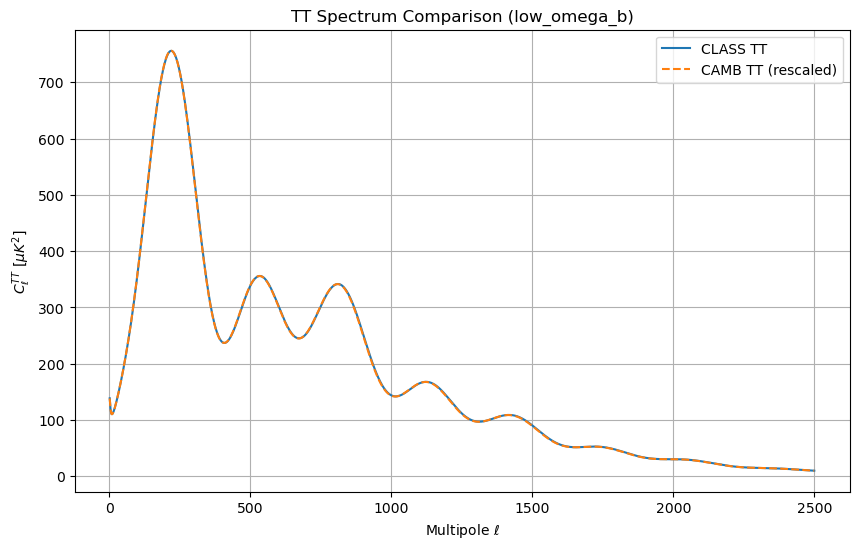

In [46]:
plot_spectra(first_result['class'], first_result['camb'], label=first_result['cosmology'])

In [10]:
# Debug: Let's see what parameters CLASS is actually using
cosmo = Class()
params = {
    'omega_b': 0.021,  # low_omega_b test case
    'omega_cdm': 0.12,
    'h': 0.6736,
    'A_s': 2.1e-9,
    'n_s': 0.9649,
    'tau_reio': 0.0544,
    'output': 'tCl pCl lCl mPk',
    'lensing': 'yes',
    'l_max_scalars': 2500
}
cosmo.set(params)
cosmo.compute()

# Check if tau_reio is being used
print(f"tau_reio: {cosmo.tau_reio()}")
print(f"Omega_b: {cosmo.Omega_b()}")
print(f"T_cmb: {cosmo.T_cmb()}")

# Get spectrum
cls = cosmo.lensed_cl(2500)
print(f"First few ℓ values: {cls['ell'][:10]}")
print(f"First few TT values: {cls['tt'][:10]}")
cosmo.struct_cleanup()

tau_reio: 0.0544
Omega_b: 0.04628232181041633
T_cmb: 2.7255
First few ℓ values: [0 1 2 3 4 5 6 7 8 9]
First few TT values: [0.00000000e+00 0.00000000e+00 1.45175394e-10 6.86794363e-11
 3.89858310e-11 2.48781594e-11 1.72205682e-11 1.26498776e-11
 9.71239870e-12 7.72082774e-12]


In [17]:
# Test the full conversion pipeline
cosmo = Class()
params = {
    'omega_b': 0.021,
    'omega_cdm': 0.12,
    'h': 0.6736,
    'A_s': 2.1e-9,
    'n_s': 0.9649,
    'tau_reio': 0.0544,
    'output': 'tCl pCl lCl mPk',
    'lensing': 'yes',
    'l_max_scalars': 2500
}
cosmo.set(params)
cosmo.compute()

cls = cosmo.lensed_cl(2500)
T_cmb = cosmo.T_cmb()

# Full conversion
ell = cls['ell']
cl_tt = cls['tt']
factor = (T_cmb * 1e6)**2
dl_tt = ell * (ell + 1) * cl_tt * factor / (2 * np.pi)

# Check values at key multipoles
for l in [2, 10, 100, 200, 500, 1000]:
    idx = l
    print(f"ℓ={l}: C_ℓ={cl_tt[idx]:.2e}, D_ℓ={dl_tt[idx]:.1f} μK²")

cosmo.struct_cleanup()

ℓ=2: C_ℓ=1.45e-10, D_ℓ=1029.8 μK²
ℓ=10: C_ℓ=6.31e-12, D_ℓ=820.5 μK²
ℓ=100: C_ℓ=2.22e-13, D_ℓ=2656.2 μK²
ℓ=200: C_ℓ=1.16e-13, D_ℓ=5493.1 μK²
ℓ=500: C_ℓ=8.48e-15, D_ℓ=2511.6 μK²
ℓ=1000: C_ℓ=9.04e-16, D_ℓ=1069.5 μK²
